In this notebook we explore Ridge Regression and what it might be good for

In [77]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
sns.set(style='ticks', palette='Set2')
%matplotlib inline

Recall that the Ordinary Least Squares (OLS) regression solution for the linear model $y = X\beta + e$, is given by

$$
\arg\min_{\beta}: \,\, \|X \beta - y\|_2^2 = \arg\min_{\beta}{\rm SSE}(\beta)
$$

Regularization adds a penalty. Ridge regression adds a squared penalty which serves to regularize and shrink the coefficients:

$$
\arg\min_{\beta}{\rm SSE}(\beta) + \lambda \sum \beta_i^2 = \arg\min_{\beta}{\rm SSE}(\beta) + \lambda \|\beta\|_2^2
$$

# Some Examples

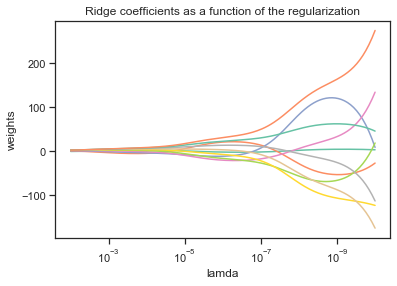

In [78]:
# A first (stylized) example of what Ridge Regression does

# Author: Fabian Pedregosa -- <fabian.pedregosa@inria.fr>
# License: BSD 3 clause

# We generate the data
# X is the 10x10 Hilbert matrix
X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y = np.ones(10)

# #############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('lamda')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Another example: Correlated / Co-linear columns

Recall that the normal equations are:
$$ \hat{\beta} = (X^{\top}X)^{-1}X^{\top}y = \beta^{\ast} + (X^{\top}X)^{-1}X^{\top} e $$

When would $X^{\top}X$ fail to be invertible, or be "close" to non-invertible?

If we have more features than data points, i.e., $n < d$, then the matrix will be non-invertible.

Even in the $d < n$ setting (more data points than features -- this is typically where we want to be) the matrix $X^{\top}X$ may fail to be invertible if the columns are co-linear.

In [103]:
# correlated columns
# Suppose p = 5, n = 500 -- a good ratio
p = 5; n = 150
X = np.random.randn(n,p)
c = np.dot(X[:,0:p-1],[2,3,-1,0.5]) + np.random.randn(1,n)/1000;
# c is a column that is approximately a linear combination of
# columns 1, 2, 3 and 4. We set the 5th column of X equal to c
X[:,p-1] = c
beta = np.array([1,1,1,1,0])
sigma = 0.3333
y = np.dot(X,beta) + sigma*np.random.randn(n)
# Now let's also generate a test data set
n1 = 500 # number of testing points
X_test = np.random.randn(n1,p)
# In the test set, there's more noise in the 5th column
c_test = np.dot(X_test[:,0:p-1],[2,3,-1,0.5]) + np.random.randn(1,n1)/50;
X_test[:,p-1] = c_test
y_test = np.dot(X_test,beta) + sigma*np.random.randn(n1)

In [104]:
# Note that the matrix Z = X'X has a very small eigenvalue.
Z = np.dot(X.T,X)
np.linalg.eig(Z)[0]

array([2.22342759e+03, 1.04918072e-05, 1.87006209e+02, 1.45749680e+02,
       1.32806632e+02])

In [89]:
# That means that its inverse has some very big eigenvalues.
# In fact, recall that the eigenvalues of the inverse matrix
# are always the inverse (one over) the eigenvalues of the original
# matrix.
np.linalg.eig(np.linalg.inv(Z))[0]

array([8.17016551e+04, 4.47400585e-04, 5.94901642e-03, 6.95819924e-03,
       6.60061916e-03])

In [90]:
# And remember that the formula for beta is
# beta_hat = (X'X)^-1 X'y
# and if we plug in: y = X beta* + Noise 
# (where beta* is the true solution), we get
# beta_hat = beta* + (X'X)^-1 X' Noise
#
# Multiplying the noise by (X'X)^-1 has the potential to blow up the noise
# and this is exactly what happens.

beta_hat = np.dot(np.dot(np.linalg.inv(Z),X.T),y.T)
print(beta_hat)

[-24.55772765 -37.32469355  13.75628748  -5.44917636  12.76847052]


To see that this is indeed "noise applification" go up a few cells and set sigma = 0 (it's set to 0.333 in the original version of this notebook). When you do that, you are setting the additive error in "y = X \beta + Noise" to zero. Hence there is no noise to amplify. Hence there are no problems with the huge eigenvalues of (X'X)^-1, and we still recover the correct answer. But even a little bit of error, and this goes out the window.

In [92]:
# Now let's compute the test error of OLS.
# You can see that it's not that good (it's big).
np.linalg.norm(np.dot(X_test,beta_hat) - y_test)

9.203314333623213

In [94]:
# For comparison, the true error for the optimal beta is:
np.linalg.norm(np.dot(X_test,beta) - y_test)

7.3937978555897805

The Ridge regression solution is:
$$ \hat{\beta}_{RR}(\lambda) = (X^{\top}X + \lambda I)^{-1}X^{\top}y $$

In [96]:
# Now we will add some regularization -- aka weight decay.
# Linear regression plus weight decay also has a closed form solution:
#
# beta_hat_R = (X'X + mu I)^-1 X'y -- compare to beta_hat = (X'X)^-1 X'y
# where I is the p by p identity matrix.
# 
# Adding a small multiple of the identity to X'X barely changes the large eigenvalues, 
# but it drastically changes the smallest eigenvalue -- it increases it to mu.
# Thus in the inverse, the largest eigenvalue will be at most 1/mu.
# Let's see this in action
#
lamda = .15
print(np.linalg.eig(Z)[0])
print(np.linalg.eig(Z + lamda*np.eye(p))[0])

[2.23513342e+03 1.22396542e-05 1.68095014e+02 1.43715344e+02
 1.51500939e+02]
[2.23528342e+03 1.50012240e-01 1.68245014e+02 1.43865344e+02
 1.51650939e+02]


In [98]:
# Now we can form the solution to the weight-decay problem, using
# the closed-form formula from above
beta_hat_R = np.dot(np.dot(np.linalg.inv(Z + mu*np.eye(p)),X.T),y.T)
print(beta_hat_R)

[0.39054599 0.11876069 1.23572529 0.76713258 0.28569303]


Note that in the above, the values are all much more controlled. There is no "error explosion" as in the OLS case. You may ask, however: why don't we recover the solution beta* = [1,1,1,1,0]? 

In fact, we cannot. Think about a case where two columns (say, columns 1 and 2) are identical. Then there's nothing the data can do to differentiate between putting weight on column 1 or column 2 or somehow splitting it between the two. {\em Any of these options produces exactly the same prediction function}. And note that since column 5 is twice the first plus 3 times the second minus the third plus 1/2 times the fourth, we have above precisely the right solution: 0.53794428 + 2 * 0.23421377 is approximately 1. 0.30061129 + 3 * 0.23421377 is approximately 1. 1.2239305 - 0.23421377 is approximately 1. And 0.87410259 + (1/2)*0.23421377 is approximately 1.

In [100]:
# Finally, let's compute the test error for the ridge regression solution.
np.linalg.norm(np.dot(X_test,beta_hat_R) - y_test)

7.79347394652098

In [101]:
# Let's again see the original solution, 
# the OLS solution (noise explosion), and the weight-decay version
# (aka ridge regression)
print(beta)
print(beta_hat)
print(beta_hat_R)

[1 1 1 1 0]
[-24.55772765 -37.32469355  13.75628748  -5.44917636  12.76847052]
[0.39054599 0.11876069 1.23572529 0.76713258 0.28569303]


In [102]:
# And let's again print the test error for the original solution,
# the OLS solution (and hence the impact of noise explosion)
# and then the weight-decay (ridge regression) version.
#
# As you can see, the Ridge-Regression solution has test error
# far far closer to the error of the true solution, than
# the OLS solution does.

print("The test error for the true solution: ", np.linalg.norm(np.dot(X_test,beta) - y_test))
print("The test error for the OLS solution: ", np.linalg.norm(np.dot(X_test,beta_hat) - y_test))
print("The test error for the Ridge Regression solution: ", np.linalg.norm(np.dot(X_test,beta_hat_R) - y_test))

The test error for the true solution:  7.3937978555897805
The test error for the OLS solution:  9.203314333623213
The test error for the Ridge Regression solution:  7.79347394652098


# Visualizing the Bias-Variance Tradeoff

In [74]:
# We repeat the entire experiment M times
M = 10000
# the regularization coeff for ridge is mu
mu = 5
beta_OLS = np.zeros(M)
beta_R5 = np.zeros(M)
beta_R10 = np.zeros(M)
beta_R25 = np.zeros(M)
beta_R50 = np.zeros(M)
for i in np.arange(M):
        n = 1000
        X = np.random.randn(n)
        beta = 1.75
        y = X*beta + np.random.randn(n)*20
        beta_OLS[i] = np.dot(X,y)/np.dot(X,X)
        beta_R5[i] = np.dot(X,y)/(np.dot(X,X)+5)
        beta_R10[i] = np.dot(X,y)/(np.dot(X,X)+10)
        beta_R25[i] = np.dot(X,y)/(np.dot(X,X)+25)
        beta_R50[i] = np.dot(X,y)/(np.dot(X,X)+50)

In [75]:
print("The mean of the OLS solution is: ", np.mean(beta_OLS))
print("The mean of the Ridge5 solution is: ", np.mean(beta_R5))
print("The mean of the Ridge10 solution is: ", np.mean(beta_R10))
print("The mean of the Ridge25 solution is: ", np.mean(beta_R25))
print("The mean of the Ridge50 solution is: ", np.mean(beta_R50))

The mean of the OLS solution is:  1.745228763906847
The mean of the Ridge5 solution is:  1.7365330340667167
The mean of the Ridge10 solution is:  1.7279236965572577
The mean of the Ridge25 solution is:  1.7026013284102424
The mean of the Ridge50 solution is:  1.6620102617898556


In [76]:
print("The standard deviation of the OLS solution is: ", np.std(beta_OLS))
print("The standard deviation of the Ridge5 solution is: ", np.std(beta_R5))
print("The standard deviation of the Ridge10 solution is: ", np.std(beta_R10))
print("The standard deviation of the Ridge25 solution is: ", np.std(beta_R25))
print("The standard deviation of the Ridge50 solution is: ", np.std(beta_R50))

The standard deviation of the OLS solution is:  0.6397927404165054
The standard deviation of the Ridge5 solution is:  0.6365926346287899
The standard deviation of the Ridge10 solution is:  0.6334247005616577
The standard deviation of the Ridge25 solution is:  0.624109104183042
The standard deviation of the Ridge50 solution is:  0.6091829397340459


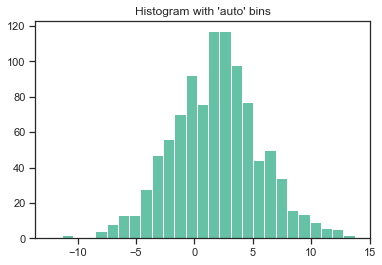

In [57]:
rng = np.random.RandomState(10)  # deterministic random data
a = np.hstack((rng.normal(size=1000),
               rng.normal(loc=5, scale=2, size=1000)))
_ = plt.hist(beta_OLS, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

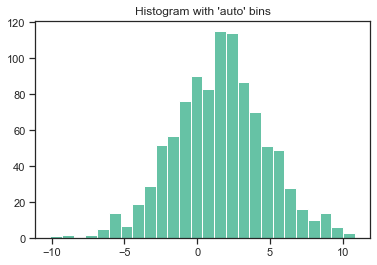

In [58]:
rng = np.random.RandomState(10)  # deterministic random data
a = np.hstack((rng.normal(size=1000),
               rng.normal(loc=5, scale=2, size=1000)))
_ = plt.hist(beta_R5, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

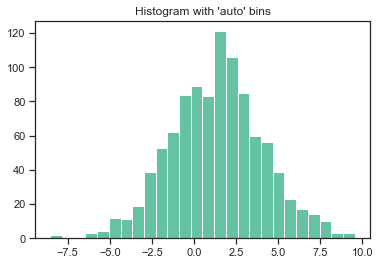

In [59]:
rng = np.random.RandomState(10)  # deterministic random data
a = np.hstack((rng.normal(size=1000),
               rng.normal(loc=5, scale=2, size=1000)))
_ = plt.hist(beta_R10, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

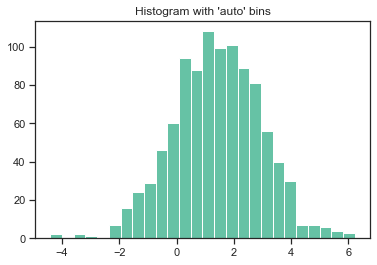

In [53]:
rng = np.random.RandomState(10)  # deterministic random data
a = np.hstack((rng.normal(size=1000),
               rng.normal(loc=5, scale=2, size=1000)))
_ = plt.hist(beta_R25, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()